<a href="https://colab.research.google.com/github/dmw1998/Case_Study_Log/blob/main/simple_OCP_for_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!pip install casadi==3.7.0
# !pip install numpy==2.2.5

In [65]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

## Euler

In [66]:
def solve_ocp_euler(k_value):
    # Time horizon
    tf = 40
    N = 100  # discretization steps
    dt = tf / N

    # Constants
    hR = 1000
    m = 4662
    g = 32.172
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    delta = 0.03491
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3

    # Wind model parameters
    a, b, c = 200, 4500, 2000
    h_star = 1000

    # Dynamics
    opti = ca.Opti()

    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    def wind_x(x_):
        return ca.if_else(x_ <= a, -k_value,
               ca.if_else(x_ <= b, -k_value + 2 * k_value * (x_ - a) / (b - a),
                          k_value))

    def wind_h(x_, h_):
        wh_val = ca.if_else(x_ < a, 0.0,
                 ca.if_else(x_ <= c, -k_value * h_ / h_star * (x_ - a) / (c - a),
                   ca.if_else(x_ <= b, -k_value * h_ / h_star * (b - x_) / (b - c), 0.0)))
        return wh_val

    # Initial conditions
    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)

    # Terminal constraint
    opti.subject_to(gamma[-1] == -0.05236)

    # Dynamics integration (Euler)
    for i in range(N):
        T = A0 + A1 * V[i] + A2 * V[i]**2
        D = 0.1 * rho * S * V[i]**2
        L = 0.5 * rho * S * (C0 + C1 * alpha[i]) * V[i]**2

        Wx = wind_x(x[i])
        Wh = wind_h(x[i], h[i])

        x_dot = V[i] * ca.cos(gamma[i]) + Wx
        h_dot = V[i] * ca.sin(gamma[i]) + Wh
        V_dot = T / m * ca.cos(alpha[i] + delta) - D / m - g * ca.sin(gamma[i])
        V_safe = ca.fmax(V[i], 1e-3)
        gamma_dot = T / (m * V_safe) * ca.sin(alpha[i] + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma[i])
        # gamma_dot = T / (m * V[i]) * ca.sin(alpha[i] + delta) + L / (m * V[i]) - g / V[i] * ca.cos(gamma[i])
        alpha_dot = u[i]

        opti.subject_to(x[i+1] == x[i] + dt * x_dot)
        opti.subject_to(h[i+1] == h[i] + dt * h_dot)
        opti.subject_to(V[i+1] == V[i] + dt * V_dot)
        opti.subject_to(gamma[i+1] == gamma[i] + dt * gamma_dot)
        opti.subject_to(alpha[i+1] == alpha[i] + dt * alpha_dot)

        # Constraints on control and alpha
        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    # Objective
    integrand = [(hR - h[i])**4 for i in range(N+1)]
    J = dt * sum(integrand)
    opti.minimize(J)

    # Initial guess
    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, ca.linspace(600, 1000, N+1))
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)

    # Solver
    # opti.solver('ipopt')
    opti.solver('ipopt', {
        'ipopt': {
            'max_iter': 5000,
            'print_level': 5,
            'tol': 1e-6,
            'linear_solver': 'mumps',  # options: 'ma57', 'ma86', 'ma97'
            'hessian_approximation': 'limited-memory',
        }
    })

    sol = opti.solve()

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u)
    }


In [67]:
result = solve_ocp_euler(k_value=20)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2006
Number of nonzeros in inequality constraint Jacobian.:      200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      605
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      506
Total number of inequality constraints...............:      200
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0995413e+11 1.32e+01 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

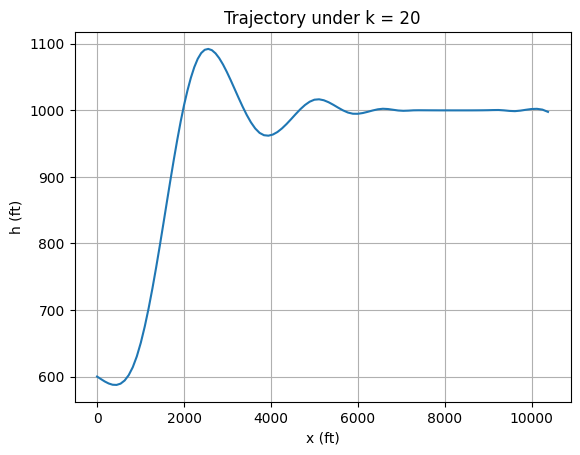

In [68]:
plt.plot(result["x"], result["h"])
plt.xlabel("x (ft)")
plt.ylabel("h (ft)")
plt.title("Trajectory under k = 20")
plt.grid()
plt.show()

In [69]:
result = solve_ocp_euler(k_value=50)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2006
Number of nonzeros in inequality constraint Jacobian.:      200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      605
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      506
Total number of inequality constraints...............:      200
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0995413e+11 2.42e+01 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

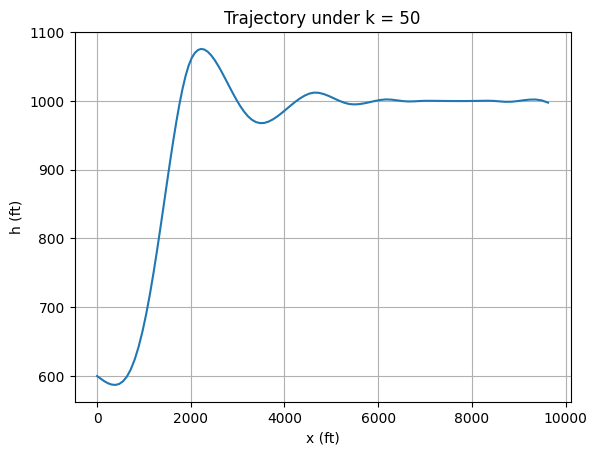

In [70]:
plt.plot(result["x"], result["h"])
plt.xlabel("x (ft)")
plt.ylabel("h (ft)")
plt.title("Trajectory under k = 50")
plt.grid()
plt.show()

## Direct Collocation

In [71]:
def solve_ocp_dir(k_value):
    tf = 40
    N = 100
    dt = tf / N

    # Parameters
    hR = 1000
    m = 4662
    g = 32.172
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    delta = 0.03491
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3
    a, b, c = 200, 4500, 2000
    h_star = 1000
    eps = 1e-6

    opti = ca.Opti()

    # State variables
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    def wind_x(x_):
        return ca.if_else(x_ <= a, -k_value,
               ca.if_else(x_ <= b, -k_value + 2 * k_value * (x_ - a) / (b - a + eps),
                          k_value))

    def wind_h(x_, h_):
        return ca.if_else(x_ < a, 0.0,
               ca.if_else(x_ <= c, -k_value * h_ / h_star * (x_ - a) / (c - a + eps),
                 ca.if_else(x_ <= b, -k_value * h_ / h_star * (b - x_) / (b - c + eps), 0.0)))

    # Dynamics definition
    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.1 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        Wx = wind_x(x_)
        Wh = wind_h(x_, h_)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh
        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_)
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_)
        alpha_dot = u_
        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    # Build integrator (RK4)
    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    ode_rhs = aircraft_ode(X_sym, u_sym)
    ode = {"x": X_sym, "p": u_sym, "ode": ode_rhs}
    intg = ca.integrator("intg", "rk", ode, {"tf": dt})

    # Initial conditions
    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    # Collocation constraints
    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        opti.subject_to(X_next == Xk_end)

        # Bounds
        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    # Objective: ∫ (hR - h)^6 dt
    J = dt * ca.sumsqr(ca.vertcat(*[(hR - h[i])**3 for i in range(N+1)]))  # equivalent to ∑ (hR - h)^6
    opti.minimize(J)

    # Initial guess
    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, ca.linspace(600, 1000, N+1))
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)

    # Solver settings
    opti.solver('ipopt', {
        'ipopt': {
            'max_iter': 5000,
            'tol': 1e-6,
            'print_level': 0,
            'linear_solver': 'mumps',
            'hessian_approximation': 'limited-memory'
        }
    })

    sol = opti.solve()

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u)
    }


In [ ]:
result = solve_ocp_dir(k_value=50)

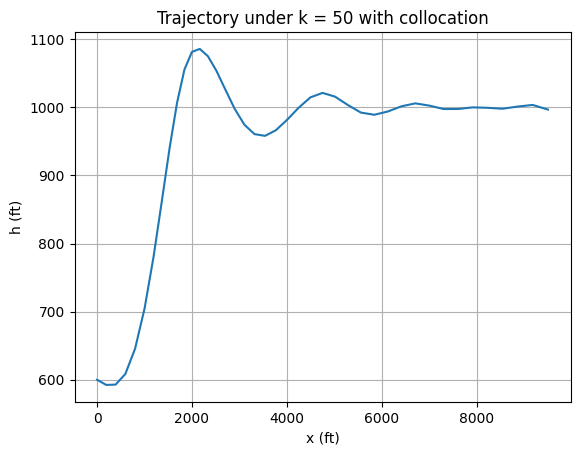

In [ ]:
plt.plot(result["x"], result["h"])
plt.xlabel("x (ft)")
plt.ylabel("h (ft)")
plt.title("Trajectory under k = 50 with collocation")
plt.grid()
plt.show()

## Uncertianty

In [ ]:
def sample_k_values(k_nominal, rel_sigma=0.25, n_samples=10, seed=42):
    np.random.seed(seed)
    epsilons = np.random.normal(loc=0.0, scale=rel_sigma, size=n_samples)
    return k_nominal * (1 + epsilons)

Sample 0: k = 56.21
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 146.45ms ( 24.18us) 146.88ms ( 24.25us)      6056
       nlp_g  | 103.99 s ( 17.17ms) 106.41 s ( 17.57ms)      6056
  nlp_grad_f  |  68.98ms ( 34.10us)  68.71ms ( 33.96us)      2023
   nlp_jac_g  | 266.47 s (129.86ms) 273.18 s (133.13ms)      2052
       total  | 389.22 s (389.22 s) 398.84 s (398.84 s)         1
Sample 1: k = 48.27


CasADi - 2025-05-17 11:24:25 WARNING("IpoptUserClass::eval_g failed:.../casadi/core/oracle_function.cpp:367: Error in solver:nlp_g:KeyboardInterrupt") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:136]


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  40.45ms ( 25.57us)  44.18ms ( 27.92us)      1582
       nlp_g  |  27.04 s ( 17.08ms)  27.32 s ( 17.26ms)      1583
  nlp_grad_f  |  22.52ms ( 32.64us)  22.46ms ( 32.55us)       690
   nlp_jac_g  |  88.41 s (128.13ms)  89.38 s (129.53ms)       690
       total  | 121.79 s (121.79 s) 123.11 s (123.11 s)         1


CasADi - 2025-05-17 11:25:21 WARNING("KeyboardInterruptException") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:132]


RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1334: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'NonIpopt_Exception_Thrown'

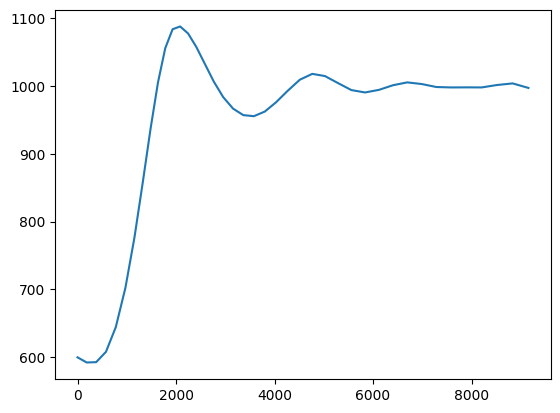

In [ ]:
k_nominal = 50
k_samples = sample_k_values(k_nominal, rel_sigma=0.25, n_samples=5)

for i, k_sample in enumerate(k_samples):
    print(f"Sample {i}: k = {k_sample:.2f}")
    result = solve_ocp_dir(k_value=k_sample)
    plt.plot(result["x"], result["h"], label=f"k = {k_sample:.1f}")

In [ ]:
plt.xlabel("x (ft)")
plt.ylabel("h (ft)")
plt.title("Trajectories under random k samples (25% σ)")
plt.grid()
plt.legend()
plt.show()

### PCE

In [ ]:
!pip install chaospy

In [ ]:
import chaospy as cp

In [ ]:
def solve_ocp(k_value):
    tf = 40
    N = 40
    dt = tf / N

    hR = 1000
    m = 4662
    g = 32.172
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    delta = 0.03491
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3
    a, b, c = 200, 4500, 2000
    h_star = 1000
    eps = 1e-6

    opti = ca.Opti()
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    def wind_x(x_):
        return ca.if_else(x_ <= a, -k_value,
               ca.if_else(x_ <= b, -k_value + 2 * k_value * (x_ - a) / (b - a + eps), k_value))

    def wind_h(x_, h_):
        return ca.if_else(x_ < a, 0.0,
               ca.if_else(x_ <= c, -k_value * h_ / h_star * (x_ - a) / (c - a + eps),
                 ca.if_else(x_ <= b, -k_value * h_ / h_star * (b - x_) / (b - c + eps), 0.0)))

    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.1 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        Wx = wind_x(x_)
        Wh = wind_h(x_, h_)
        V_safe = ca.fmax(V_, 1e-3)
        return ca.vertcat(
            V_ * ca.cos(gamma_) + Wx,
            V_ * ca.sin(gamma_) + Wh,
            T/m * ca.cos(alpha_ + delta) - D/m - g * ca.sin(gamma_),
            T/(m * V_safe) * ca.sin(alpha_ + delta) + L/(m * V_safe) - g/V_safe * ca.cos(gamma_),
            u_
        )

    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    ode_rhs = aircraft_ode(X_sym, u_sym)
    ode = {"x": X_sym, "p": u_sym, "ode": ode_rhs}
    intg = ca.integrator("intg", "rk", ode, {"tf": dt})

    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        opti.subject_to(X_next == Xk_end)
        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    # Objective
    J = dt * ca.sumsqr(ca.vertcat(*[(hR - h[i])**3 for i in range(N+1)]))
    opti.minimize(J)

    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, ca.linspace(600, 1000, N+1))
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)

    opti.solver('ipopt', {
        'ipopt': {
            'max_iter': 1000,
            'tol': 1e-6,
            'print_level': 0,
            'linear_solver': 'mumps',
            'hessian_approximation': 'limited-memory'
        }
    })

    sol = opti.solve()
    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "J": sol.value(J),
    }


In [ ]:
def pce_uncertainty_analysis(k0=50, rel_sigma=0.25, order=3):
    # Standard normal input ξ ~ N(0,1)
    dist = cp.Normal(0, 1)
    basis = cp.orth_ttr(order, dist)
    nodes, weights = cp.generate_quadrature(order+1, dist, rule="gaussian")

    Js = []
    for i, xi in enumerate(nodes[0]):
        k_sample = k0 * (1 + rel_sigma * xi)
        print(f"Solving OCP at k = {k_sample:.2f}")
        result = solve_ocp(k_sample)
        Js.append(result["J"])

    # PCE coefficients
    coeffs = cp.fit_quadrature(basis, nodes, weights, Js)
    J_pce = cp.callable_trunc(basis, coeffs)

    # Sampling
    samples = dist.sample(1000)
    J_samples = J_pce(*samples)

    print(f"J mean ≈ {np.mean(J_samples):.2f}")
    print(f"J std  ≈ {np.std(J_samples):.2f}")

    plt.hist(J_samples, bins=30)
    plt.title("Histogram of J(k) from PCE")
    plt.xlabel("J")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


In [ ]:
pce_uncertainty_analysis(k0=50, rel_sigma=0.25, order=3)